# Rewriting Activation Maps  
**An Encoder Network that Enables a Pre-trained StyleGAN2 Model to Perform Image-to-image Translation**  
###### Coding Three: Exploring Machine Intelligence   

Author: Jasper Zheng (Shuoyang) / 21009460  

<img src='./docs/leaf.jpg' width='500px'></img>

This project proposed a novel training system appended to [StyleGAN2](https://github.com/NVlabs/stylegan2) architecture, enabling a pre-trained StyleGAN2 model to perform image-to-image translation, even if the input images are not in the original domain. The training system is based on an encoder network that downscales the generated images from a StyleGAN2 model and matches the distribution of the earlier activation maps in the same model (i.e. predict feature maps given a generated image). After training, the encoder network is migrated to the StyleGAN2 model.   

The proposed system was implemented on a couple of pre-trained models. And the results showed that it's able to create meaningful image-to-image translation different with [pix2pixHD](https://github.com/NVIDIA/pix2pixHD) and other state-of-the-art image translation models.  

In addition, a real-time interactive system was built to facilitate human control of the network.   




The StyleGAN2 implementation borrowed heavily from [moono/stylegan2-tf-2.x](https://github.com/moono/stylegan2-tf-2.x)   

## Requirements:  

In [ ]:
!pip install tensorflow==2.3.0
!pip install tensorflow-addons==0.13.0
!pip install numpy==1.19.0

In [ ]:
!git clone https://github.com/jasper-zheng/rewriting-activation-maps.git 

## Init  

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun 19 13:51:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%cd /content/rewriting-activation-maps/stylegan2_tf2
!nvcc test_nvcc.cu -o test_nvcc -run

/content/rewriting-activation-maps/stylegan2_tf2
CPU says hello.
GPU says hello.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from stylegan2.generator import load_and_restore
from stylegan2.utils import postprocess_images
from stylegan2.layers.cuda.upfirdn_2d_v2 import upsample_2d, compute_paddings

from PIL import Image
import os, os.path

# _Set Memory Growth:

from tensorflow import config, test
from tensorflow import __version__ as tf_version

physical_devices = config.list_physical_devices('GPU')
config.experimental.set_memory_growth(physical_devices[0], True)

print(physical_devices)
print(tf_version)
print(f'tf is using cuda: {test.is_built_with_cuda()}')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.0
tf is using cuda: True


## Download and Load the Trained Models

Here we download the pre-trained StyleGAN2 model, and the trained encoder model

#### Option 1: Painting Faces (MetFaces) Model

In [ ]:
!gdown --id 1-3AncVaH__aSwiGYPSyQC4n9ou1wW0y0
!gdown --id 1-9yA55QXj_6qBfNLwC-IBU7T9DXmJnSr

In [ ]:
!rm -r ./pretrained_metface/
!rm -r ./trained_encoder_metfaces/
!unzip ./pretrained_metface.zip
!unzip ./trained_encoder_metfaces.zip

In [ ]:
generator = load_and_restore('./pretrained_metface/cuda')

Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


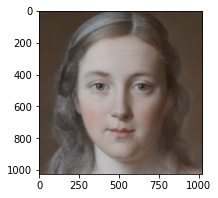

In [5]:
seed = 2291
rnd = np.random.RandomState(seed)

latents = rnd.randn(1, generator.z_dim).astype(np.float32)
labels = rnd.randn(1, generator.labels_dim).astype(np.float32)
image_out,intermediate_y = generator([latents, labels], 
                                    ret_w_broadcasted=False, 
                                    training=False, 
                                    truncation_psi=0.6,
                                    return_intermediate_y=True)
plt.figure(figsize=(3,3))
plt.imshow(postprocess_images(image_out)[0])

#### Option 2: Leaf Model

In [ ]:
!gdown --id 1-7WxnuhyRbQnIt-n9qQ3BYXJkvnaN_6f
!gdown --id 1-Bd2SNApEGeWBa3DyPfIvZAG8rWtrq8G

In [ ]:
!rm -r ./pretrained_leaf/
!rm -r ./trained_encoder_leaf/
!unzip ./pretrained_leaf.zip
!unzip ./trained_encoder_leaf.zip

In [ ]:
generator = load_and_restore('./pretrained_leaf/cuda')

In [ ]:
seed = 2291
rnd = np.random.RandomState(seed)

latents = rnd.randn(1, generator.z_dim).astype(np.float32)
labels = rnd.randn(1, generator.labels_dim).astype(np.float32)
image_out,intermediate_y = generator([latents, labels], 
                                    ret_w_broadcasted=False, 
                                    training=False, 
                                    truncation_psi=0.6,
                                    return_intermediate_y=True)
plt.figure(figsize=(3,3))
plt.imshow(postprocess_images(image_out)[0])

## Disassemble the StyleGAN2 Model  

Then we open the synthesise network, manually setup the inference pipeline. Therefore we can extract the intermediate activation maps.  

In [6]:
k, pad0, pad1 = compute_paddings([1, 3, 3, 1], None, up=True, down=False, is_conv=False)

dlatents = generator.layers[0]([latents, labels])
w_broadcasted = generator.layers[1](dlatents)
w_broadcasted_t = generator.truncation_trick(w_broadcasted, 0.6)
print(f'latent vector: {dlatents.shape}, \nbroadcasted latent vector: {w_broadcasted_t.shape}')

latent vector: (1, 512), 
broadcasted latent vector: (1, 18, 512)


In [7]:
%%time

inputs = tf.concat([w_broadcasted_t,w_broadcasted],axis=0)

y4 = generator.layers[2].initial_block(inputs[:, 0])

y8 = generator.layers[2].blocks[0].conv_0([y4,inputs[:, 0]])
y8 = generator.layers[2].blocks[0].apply_noise_0(y8)
y8 = generator.layers[2].blocks[0].apply_bias_act_0(y8)
y8_1 = generator.layers[2].blocks[0].conv_1([y8,inputs[:, 0]])
y8_1 = generator.layers[2].blocks[0].apply_noise_1(y8_1)
y8_1 = generator.layers[2].blocks[0].apply_bias_act_1(y8_1)

y16 = generator.layers[2].blocks[1].conv_0([y8_1,inputs[:, 0]])
y16 = generator.layers[2].blocks[1].apply_noise_0(y16)
y16 = generator.layers[2].blocks[1].apply_bias_act_0(y16)
y16_1_cov = generator.layers[2].blocks[1].conv_1([y16,inputs[:, 0]])

CPU times: user 247 ms, sys: 1.03 ms, total: 248 ms
Wall time: 251 ms


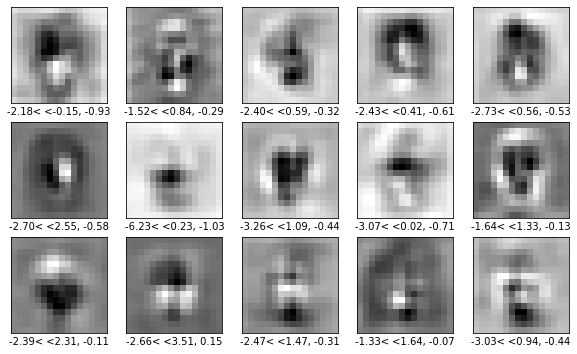

In [8]:
# _Plot 15 images by matplotlib.pyplot

plt.figure(figsize=(10,6))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(y16_1_cov[0][i], cmap='gray')
    plt.xlabel(f'{np.min(y16_1_cov[0][i]):.2f}< <{np.max(y16_1_cov[0][i]):.2f}, {np.mean(y16_1_cov[0][i]):.2f}')
plt.show()

## Build the Appended Encoder  

Now we build the appended encoder.  

In [9]:
class MeanFilter(tf.keras.layers.Layer):
  def __init__(self):
    super(MeanFilter, self).__init__()

  def build(self,input_shape):
      self.compute_output_shape(input_shape)
      
  def compute_output_shape(self, inputs):
    self._spatial_output_shape(inputs)
    return inputs

  def _spatial_output_shape(self, spatial_input_shape):
    return spatial_input_shape

  def call(self, inputs):
    return tfa.image.mean_filter2d(inputs)

In [10]:
inputs_re = tf.keras.Input((256, 256, 3))

x = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same')(inputs_re)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 128,128,64

x = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 64,64,128

x = tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = MeanFilter()(x)

x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 32,32,512

x = tf.keras.layers.Conv2D(512, (3,3), strides=(2,2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 16,16,512

x = tf.keras.layers.Conv2D(512, (3,3), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 16,16,512

x = tf.keras.layers.Conv2D(512, (1,1), padding='same')(x)

model_re = tf.keras.Model(inputs=inputs_re, outputs=x)

In [11]:
model_re.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 64, 64, 128)      

## Build the Training System  

Now we set up the training loop defined in the graph below.  

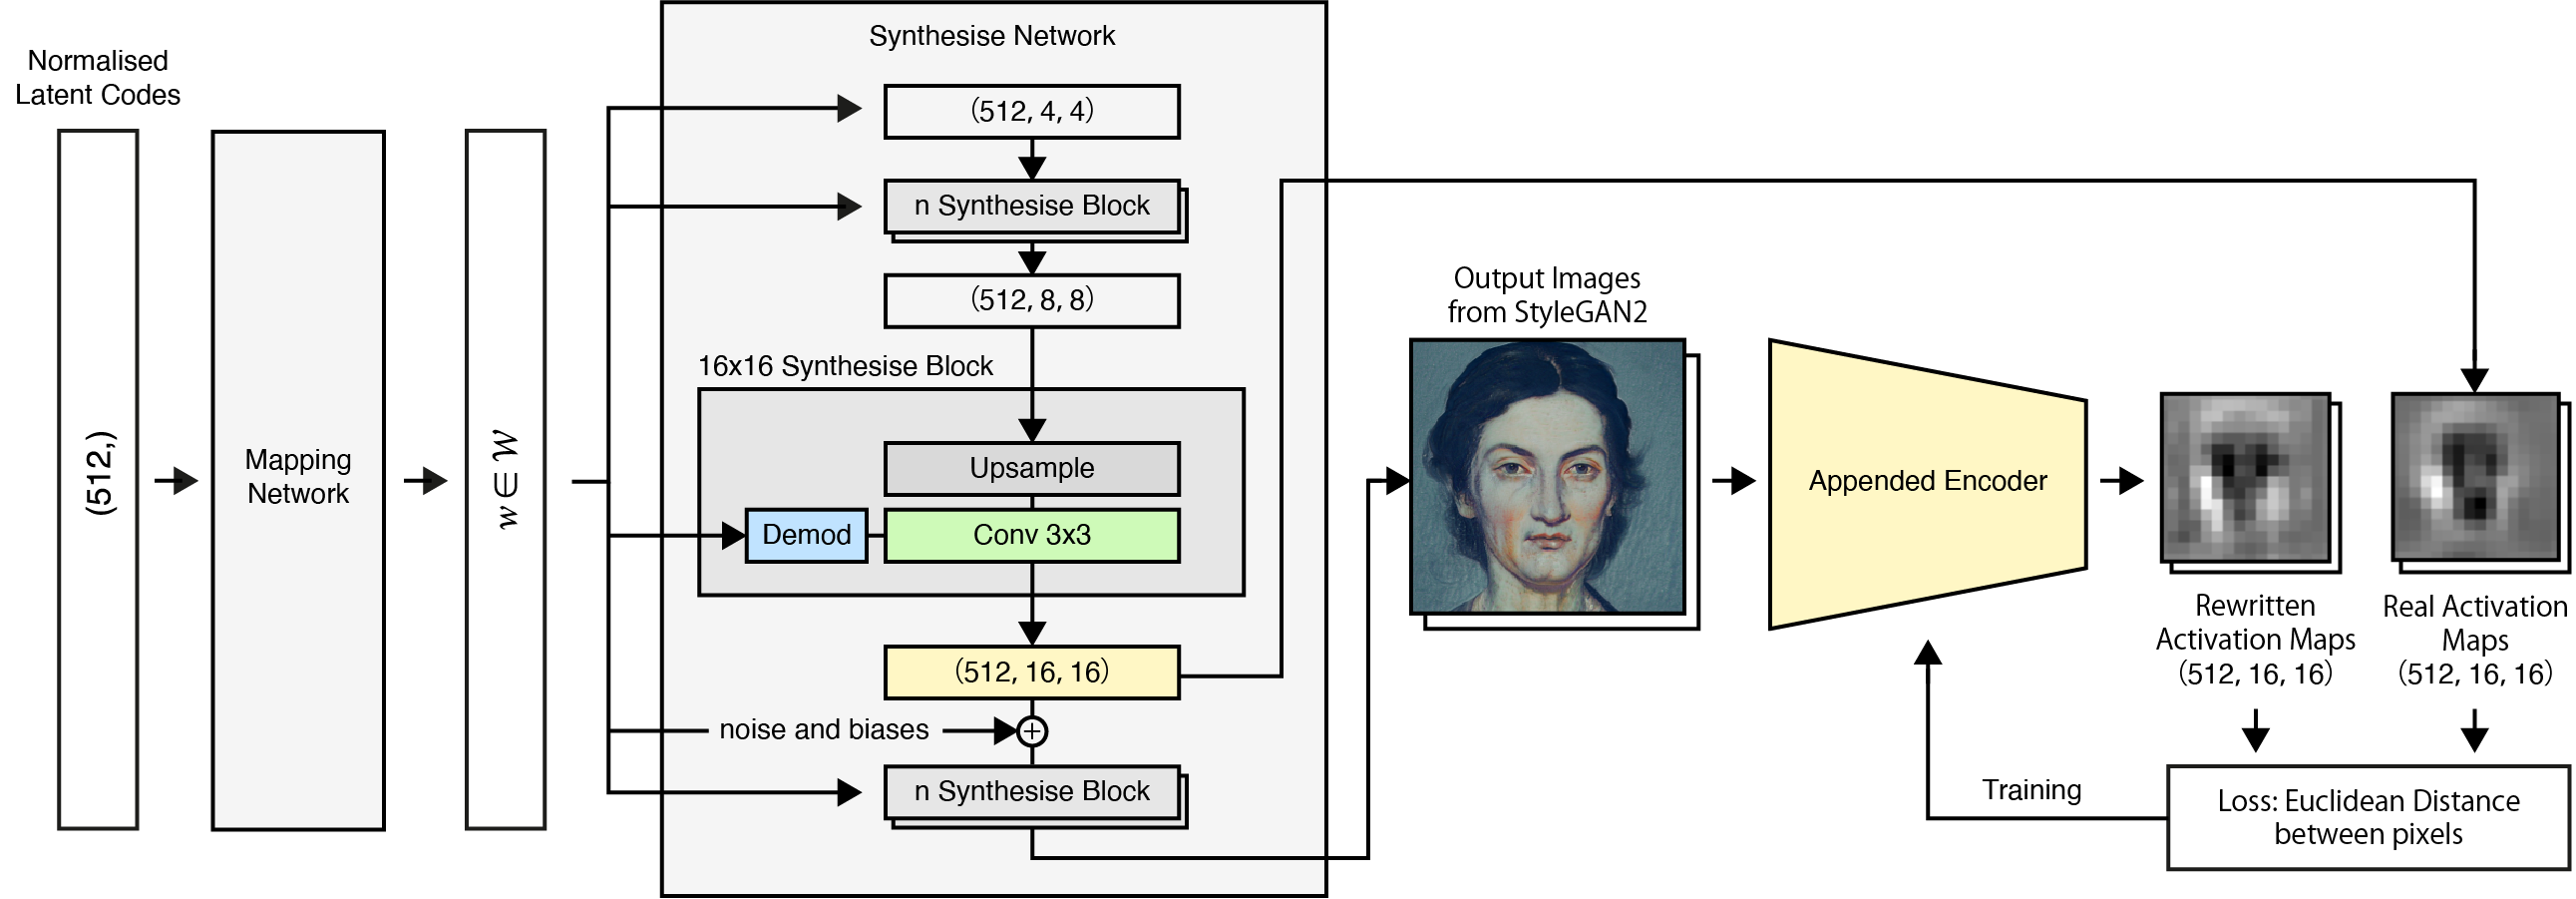

In [12]:
Image.open('../docs/graph_encoer_network.png')

In [ ]:
!mkdir /content/visual

In [14]:
def rewrite_and_generate(new_model, img, broadcasted, output_res = 1024):
  # img: BHWC

  pred = new_model.predict(img)
  features_2 = tf.transpose(pred, [0,3,1,2])

  inputs=broadcasted

  y16_1 = generator.layers[2].blocks[1].apply_noise_1(features_2)
  y16_1 = generator.layers[2].blocks[1].apply_bias_act_1(y16_1)
  y32 = generator.layers[2].blocks[2].conv_0([y16_1,inputs[:, 0]])
  y32 = generator.layers[2].blocks[2].apply_noise_0(y32)
  y32 = generator.layers[2].blocks[2].apply_bias_act_0(y32)
  y32_1 = generator.layers[2].blocks[2].conv_1([y32,inputs[:, 0]])
  y32_1 = generator.layers[2].blocks[2].apply_noise_1(y32_1)
  y32_1 = generator.layers[2].blocks[2].apply_bias_act_1(y32_1)
  y64 = generator.layers[2].blocks[3]([y32_1,inputs[:, 0],inputs[:, 0]])
  y128 = generator.layers[2].blocks[4]([y64,inputs[:, 0],inputs[:, 0]])
  y128_rgb = generator.layers[2].torgbs[4]([y128, inputs[:, 0]])
  y256 = generator.layers[2].blocks[5]([y128,inputs[:, 0],inputs[:, 0]])
  y256_rgb = upsample_2d(y128_rgb, generator.layers[2].blocks[5].res//2, pad0, pad1, k)
  y256_rgb = y256_rgb + generator.layers[2].torgbs[5]([y256, inputs[:, 0]])
  y512 = generator.layers[2].blocks[6]([y256,inputs[:, 0],inputs[:, 0]])
  y512_rgb = upsample_2d(y256_rgb, generator.layers[2].blocks[6].res//2, pad0, pad1, k)
  y512_rgb = y512_rgb + generator.layers[2].torgbs[6]([y512, inputs[:, 0]])
  y1024 = generator.layers[2].blocks[7]([y512,inputs[:, 0],inputs[:, 0]])
  y1024_rgb = upsample_2d(y512_rgb, generator.layers[2].blocks[7].res//2, pad0, pad1, k)
  y_rgb = y1024_rgb + generator.layers[2].torgbs[7]([y1024, inputs[:, 0]])

  if output_res==1024:
    image_post = postprocess_images(y_rgb).numpy()
  elif output_res==512:
    y_small = tf.keras.layers.MaxPool2D(pool_size=(2,2),data_format='channels_first')(y_rgb)
    image_post = postprocess_images(y_small).numpy()
  elif output_res==256:
    y_small = tf.keras.layers.MaxPool2D(pool_size=(2,2),data_format='channels_first')(y_rgb)
    y_small = tf.keras.layers.MaxPool2D(pool_size=(2,2),data_format='channels_first')(y_small)
    image_post = postprocess_images(y_small).numpy()
  else:
    image_post = postprocess_images(y_rgb).numpy()
  
  return image_post #BHWC

In [15]:
def load_img_to_tensor(path,size=1024):
  img = Image.open(path)
  w,h = img.size

  if w==h:
    img = img.resize((size,size)).convert('RGB')

  elif w>h:
    img = img.crop(((w-h)/2,0,(w-h)/2+h,h)).resize((size,size)).convert('RGB')

  elif h>w:
    img = img.crop((0,(h-w)/2,w,(h-w)/2+w)).resize((size,size)).convert('RGB')
  
  loaded = tf.convert_to_tensor(np.array(img),dtype=tf.float32)/127.5 -1.0
  return tf.expand_dims(loaded,axis=0)

def test_generator(img_path,new_model,i = 0, input_size=256):
  img = load_img_to_tensor(img_path,input_size)
  processes = rewrite_and_generate(new_model,img,w_broadcasted_t)
    
  fig = plt.figure(figsize=(7, 7))

  plt.imshow(processes[0])
  plt.savefig(f'/content/visual/image_at_step_{i:04d}.jpg')
  plt.show()


In [16]:
from IPython.display import clear_output

def forward(w_broadcasted, generator):
  inputs = w_broadcasted

  y4 = generator.layers[2].initial_block(inputs[:, 0])

  y8 = generator.layers[2].blocks[0].conv_0([y4,inputs[:, 0]])
  y8 = generator.layers[2].blocks[0].apply_noise_0(y8)
  y8 = generator.layers[2].blocks[0].apply_bias_act_0(y8)
  y8_1 = generator.layers[2].blocks[0].conv_1([y8,inputs[:, 0]])
  y8_1 = generator.layers[2].blocks[0].apply_noise_1(y8_1)
  y8_1 = generator.layers[2].blocks[0].apply_bias_act_1(y8_1)

  y16 = generator.layers[2].blocks[1].conv_0([y8_1,inputs[:, 0]])
  y16 = generator.layers[2].blocks[1].apply_noise_0(y16)
  y16 = generator.layers[2].blocks[1].apply_bias_act_0(y16)
  y16_1_cov = generator.layers[2].blocks[1].conv_1([y16,inputs[:, 0]])
  y16_1 = generator.layers[2].blocks[1].apply_noise_1(y16_1_cov)
  y16_1 = generator.layers[2].blocks[1].apply_bias_act_1(y16_1)

  y32 = generator.layers[2].blocks[2].conv_0([y16_1,inputs[:, 0]])
  y32 = generator.layers[2].blocks[2].apply_noise_0(y32)
  y32 = generator.layers[2].blocks[2].apply_bias_act_0(y32)
  y32_1 = generator.layers[2].blocks[2].conv_1([y32,inputs[:, 0]])
  y32_1 = generator.layers[2].blocks[2].apply_noise_1(y32_1)
  y32_1 = generator.layers[2].blocks[2].apply_bias_act_1(y32_1)

  y64 = generator.layers[2].blocks[3]([y32_1,inputs[:, 0],inputs[:, 0]])
  y128 = generator.layers[2].blocks[4]([y64,inputs[:, 0],inputs[:, 0]])
  y128_rgb = generator.layers[2].torgbs[4]([y128, inputs[:, 0]])

  y256 = generator.layers[2].blocks[5]([y128,inputs[:, 0],inputs[:, 0]])
  y256_rgb = upsample_2d(y128_rgb, generator.layers[2].blocks[5].res//2, pad0, pad1, k)
  y256_rgb = y256_rgb + generator.layers[2].torgbs[5]([y256, inputs[:, 0]])

  y512 = generator.layers[2].blocks[6]([y256,inputs[:, 0],inputs[:, 0]])
  y512_rgb = upsample_2d(y256_rgb, generator.layers[2].blocks[6].res//2, pad0, pad1, k)
  y512_rgb = y512_rgb + generator.layers[2].torgbs[6]([y512, inputs[:, 0]])

  y1024 = generator.layers[2].blocks[7]([y512,inputs[:, 0],inputs[:, 0]])
  y1024_rgb = upsample_2d(y512_rgb, generator.layers[2].blocks[7].res//2, pad0, pad1, k)
  y_rgb = y1024_rgb + generator.layers[2].torgbs[7]([y1024, inputs[:, 0]])

  x_train_1024 = tf.transpose(y_rgb, [0,2,3,1])

  x_train_1024 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_train_1024)
  x_train = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_train_1024)

  y_train = tf.transpose(y16_1_cov, [0,2,3,1])

  return x_train, y_train

def train_epochs(model_re, generator, epochs_num, batch_num, batch_per_epo, latent_dim = 512):
  n_steps = batch_per_epo * epochs_num
  seed = 1
  rnd = np.random.RandomState(seed)
  loss = []

  for i in range(n_steps):

    # latent points
    latents = rnd.randn(batch_num, 512).astype(np.float32)
    labels = rnd.randn(batch_num, 0).astype(np.float32)

    dlatents = generator.layers[0]([latents, labels])
    w_broadcasted = generator.layers[1](dlatents)

    # forward pass
    train_x_batch, train_y_batch = forward(w_broadcasted, generator)

    # train on batch
    g_loss = model_re.train_on_batch(train_x_batch, train_y_batch)
    loss.append(g_loss)

    if i%10 == 0:
      clear_output(wait=True)
      print(f'step: {i:03}, loss: [{g_loss[0]:.4f}, {g_loss[1]:.4f}]')
      test_generator('./test_imgs/Untitled-4.jpg',model_re,i)
    elif i%1 == 0:
      print(f'step: {i:03}, loss: [{g_loss[0]:.4f}, {g_loss[1]:.4f}]')

  return loss

## Compile and Train the Encoder Network  
Or load the trained encoder in the next step

In [17]:
model_re.compile(optimizer = 'Adam', loss = tf.keras.metrics.mean_squared_error, metrics = ['accuracy'] )

step: 090, loss: [0.7845, 0.4609]


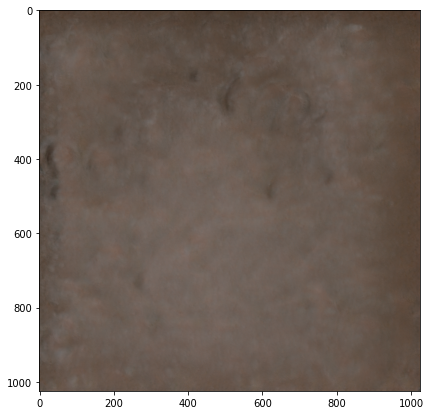

step: 091, loss: [0.5748, 0.5127]
step: 092, loss: [0.6612, 0.4436]
step: 093, loss: [0.8404, 0.4915]
step: 094, loss: [0.6789, 0.4822]
step: 095, loss: [0.6605, 0.5107]
step: 096, loss: [0.4909, 0.4219]
step: 097, loss: [0.6453, 0.4331]
step: 098, loss: [0.7060, 0.4895]
step: 099, loss: [0.5325, 0.4414]


In [18]:
epochs_num = 1 # increase this number to something like 20 - 30

losses = train_epochs(model_re, generator, epochs_num=epochs_num, batch_num=16, batch_per_epo=100, latent_dim = 512)

In [ ]:
checkpoint_path = "./model_rebuild/training_metface_new/"
!mkdir {checkpoint_path}
model_re.save(checkpoint_path)

## Load the Trained Encoder

If you chose Leaf:

In [ ]:
appended_encoder = tf.keras.models.load_model('./trained_encoder_leaf')

If you chose MetFaces:

In [19]:
appended_encoder = tf.keras.models.load_model('./trained_encoder_metfaces')

## Check the Reproduced Activation Maps  

In [24]:
test_image_path = './test_imgs/Untitled-4.jpg'

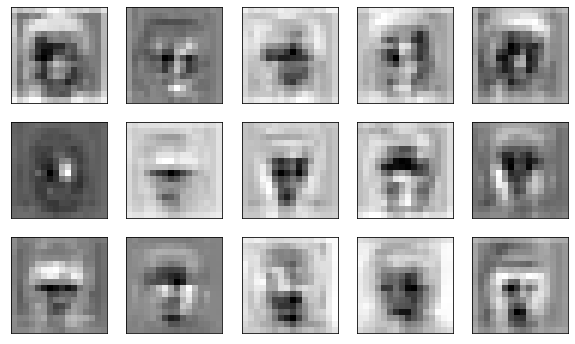

In [25]:
img = load_img_to_tensor(test_image_path,256)

pred = appended_encoder.predict(img)
features = tf.transpose(pred, [0,3,1,2])

plt.figure(figsize=(10,6))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(features[0][i],cmap = 'gray')
plt.show()

## Deploy the Encoder to StyleGAN2 Model

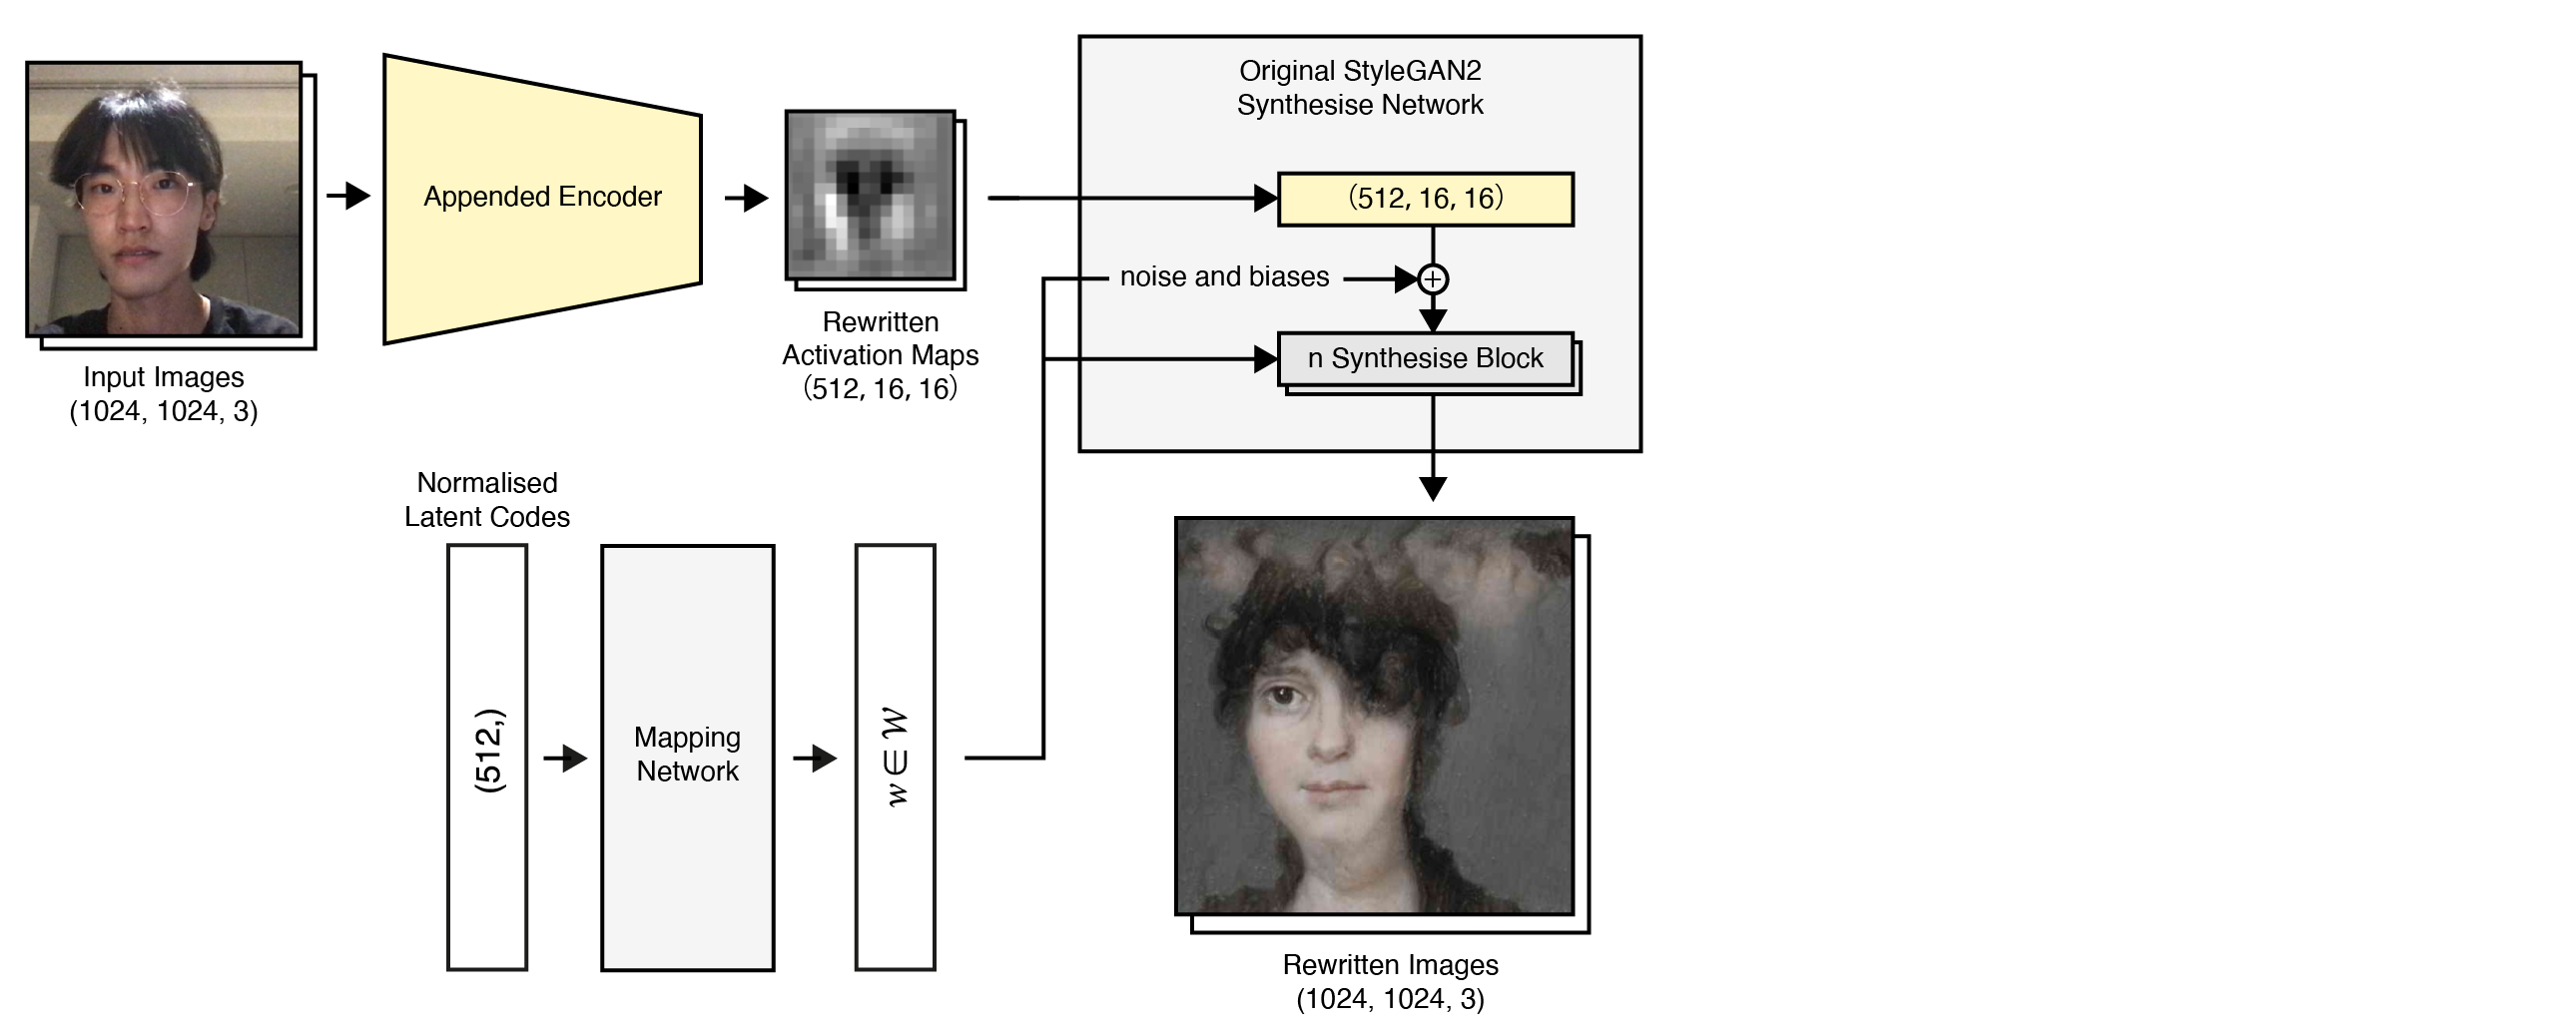

In [46]:
Image.open('../docs/graph_deployed_network.png')

In [41]:
test_image_path = './test_imgs/2.jpg'

In [44]:
img = load_img_to_tensor(test_image_path,size=256)
processed = rewrite_and_generate(appended_encoder, img, w_broadcasted_t, output_res=1024)

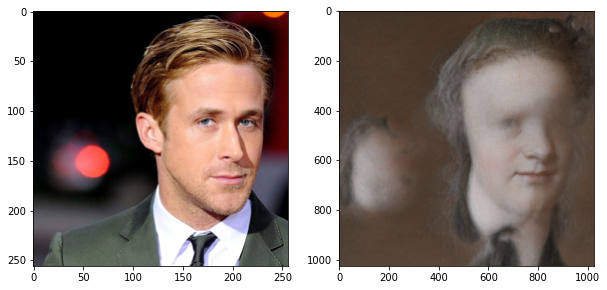

In [45]:
plt.figure(figsize=(21,11))
for i,image in enumerate([img/2+0.5, processed]):
    plt.subplot(1,4,i+1)
    plt.imshow(image[0])
plt.show()

## Real-time Implementation  

#### Setup the JS framework

In [49]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import time

import io,os
from PIL import Image
import numpy as np


In [50]:
js_setup_camera = Javascript('''

  const capture_size = 256

  var table = document.createElement('table');
  var td_right = document.createElement('td');
  
  var td_left = document.createElement('td');
  table.appendChild(td_left);
  table.appendChild(td_right);

  var video = document.createElement('video');
  video.style.display = 'block';

  var canvas = document.createElement('canvas');
  var return_canvas = document.createElement('img');

  var stream
  async function setupCamera(video, table, stream, canvas, return_canvas){
    stream = await navigator.mediaDevices.getUserMedia({video: { width: capture_size, height: capture_size }});
    document.body.appendChild(table);
    td_left.appendChild(video);
    video.srcObject = stream;
    await video.play();

    await google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    canvas.getContext('2d').drawImage(video, 0, 0);

    td_right.appendChild(return_canvas);
  }
  setupCamera(video, table, stream, canvas, return_canvas);
  var listenerChannel = new BroadcastChannel('video_controller');
  listenerChannel.onmessage = (event) => {
    console.log('stop video');
    video.srcObject.getVideoTracks()[0].stop();
  };

  async function extract_frame(quality, return_bytes){
    await canvas.getContext('2d').drawImage(video, 0, 0);
    return_canvas.src = return_bytes
    return canvas.toDataURL('image/jpeg', quality);
    // return 0
  }
''')

def pil_to_bytes(img,return_quality=75):
  iobuf = io.BytesIO()
  img.save(iobuf, format='JPEG', quality=return_quality)
  return f'data:image/jpeg;base64,{str(b64encode(iobuf.getvalue()), "utf-8")}'


#### Start!  

In [53]:
display(js_setup_camera)
quality = 0.2
time.sleep(2)
return_size = 512
return_quality = 30 # [25,75)
interpolation_step = 25

img = np.zeros((return_size,return_size,3))
return_PIL = Image.fromarray(img, 'RGB')
return_bytes = pil_to_bytes(return_PIL)

for i in range(1000):
  exc_data = f'extract_frame({quality}, "{return_bytes}")'
  data = eval_js(exc_data)
  binary = b64decode(data.split(',')[1])
  img = np.array(Image.open(io.BytesIO(binary))) # HWC 255 -> 
  
  # do something here: 

  img = tf.convert_to_tensor(img,dtype=tf.float32)/127.5 - 1.0
  processed = rewrite_and_generate(appended_encoder, tf.expand_dims(img,axis=0), w_broadcasted_t, output_res=return_size)
  
  # -> BHWC 255
  return_PIL = Image.fromarray(processed[0],'RGB')
  return_bytes = pil_to_bytes(return_PIL, return_quality)


<IPython.core.display.Javascript object>

#### Run this cell to close the camera

In [54]:
%%javascript
const senderChannel = new BroadcastChannel('video_controller');
senderChannel.postMessage('stop');

<IPython.core.display.Javascript object>